In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from collections import defaultdict

from IPython.display import Latex, display

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [111]:
color_mapping = {
    k: v for k, v in zip(
        ["CBL", "Bufboss", "Bifrost-1", "BSBWT", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        sns.color_palette())
}
name_mapping = {
 k: v for k, v in zip(
        ["CBL", "Bufboss", "Bifrost-1", "BSBWT", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["CBL",  "BufBOSS",   "Bifrost", "DSBWT", "DSBWT 4t 0.5G", "DSBWT 16t 4G", "Bifrost 32t", "DSBWT 32t 30G"])
}  
marker_mapping = {
 k: v for k, v in zip(
        ["CBL", "Bufboss", "Bifrost-1", "BSBWT", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["o", "X", "s", "^", ">", "<", "d", "v"])
}  

In [112]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    searched = []
    found = []
    time = 0
    query_time = 0
    rss = 0
    threads = 1
    ds_type = None
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif line.startswith("# query time"):
                query_time = int(line.split()[-1]) / 1000000000
            elif "Time for all queries" in line:
                query_time = float(line.split()[-2])
            elif line.startswith("Query time ns:"):
                query_time = int(line.split()[-1]) / 1000000000
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "Bifrost":
                            data[f"{ds_type}-{threads}"].append((time, rss, query_time))
                        else:
                            data[ds_type].append((time, rss, query_time))
            elif line.startswith("Saw "):
                elems = int(line.split()[1])
                searched.append(elems)
            elif line.startswith("matched"):
                ss = line.split()
                query_time = float(ss[-2]) / 1000
                elems = int(ss[1])
                found.append(elems)
            elif "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
            elif line.startswith("threads"):
                threads = 32
    return {
        "size": sizes, 
        "searched": searched,
        "found": found,
        "data": data
    }

In [113]:
def plot_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[2] * 1000**3 / s for vv, s in zip(v, res["searched"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time (ns / k-mer)")
    plt.legend()
    plt.title("query time")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (bits / k-mer)")
    plt.legend()
    plt.title("memory efficiency")
    a, b = plt.ylim()
    plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [114]:
def plot_total_time_and_space(res, title, name=None):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[0] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("Query time (s)")
    plt.legend()
    plt.title("query time total")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (bytes)")
    plt.legend()
    plt.title("RSS")
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

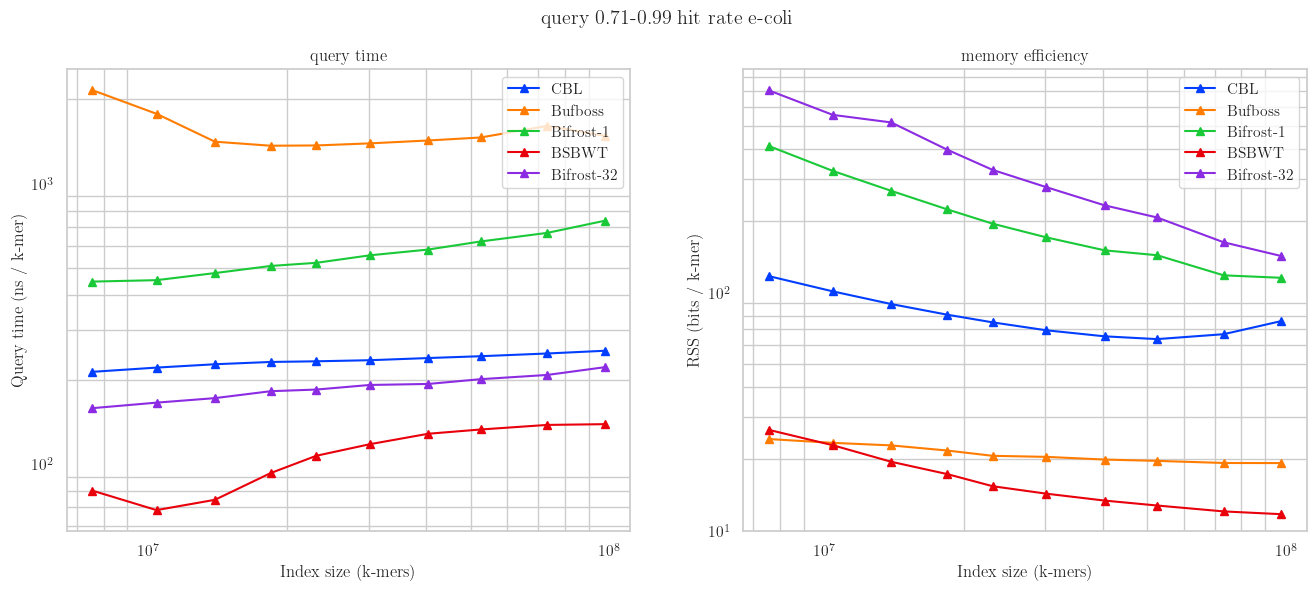

In [115]:
coli_res = read_res("../bbb_res/query_coli.txt")
h_r = [b / a for a, b in zip(coli_res["searched"], coli_res["found"])]
plot_time_and_space(coli_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli", "query_e-coli_mixed.pdf")

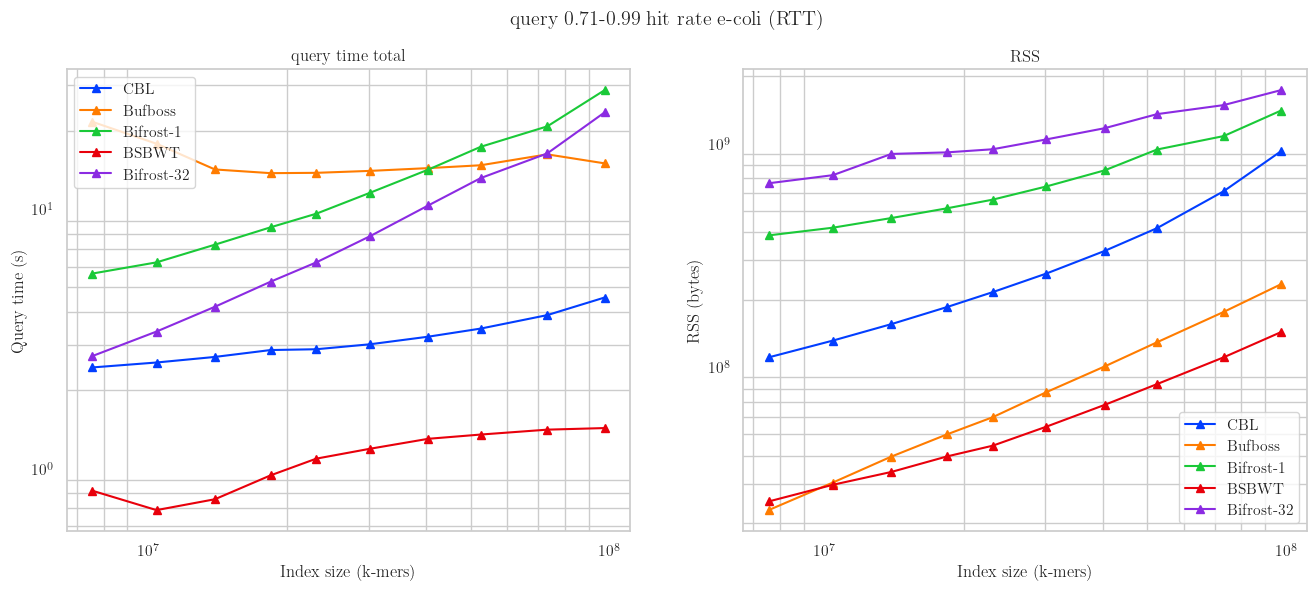

In [116]:
plot_total_time_and_space(coli_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate e-coli (RTT)", "query_e-coli_mixed_RTT.pdf")

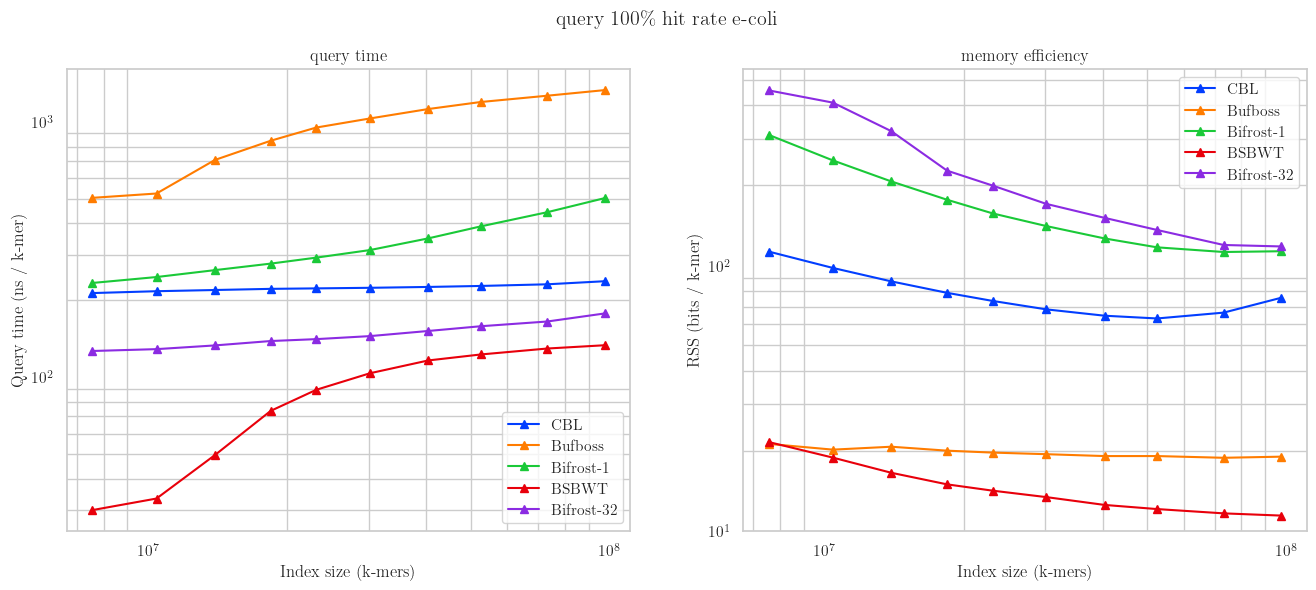

In [117]:
coli_res_pos = read_res("../bbb_res/query_coli_pos.txt")
h_r = [b / a for a, b in zip(coli_res_pos["searched"], coli_res_pos["found"])]
plot_time_and_space(coli_res_pos, f"query 100\\% hit rate e-coli", "query_e-coli_pos.pdf")

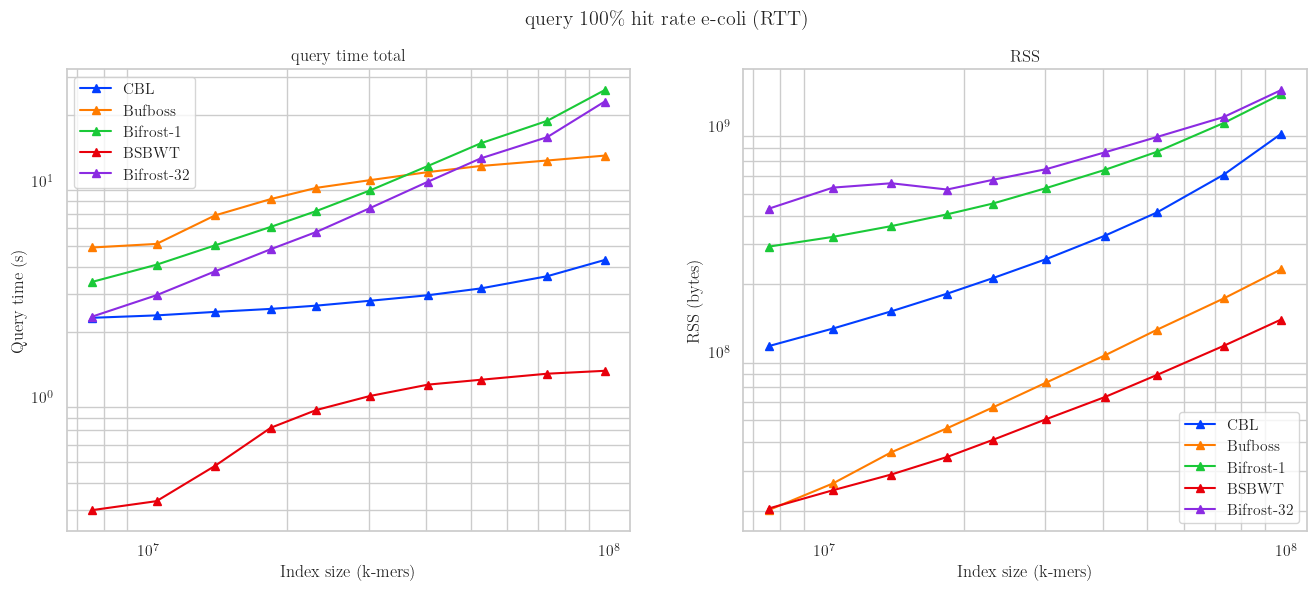

In [118]:
plot_total_time_and_space(coli_res_pos, f"query 100\\% hit rate e-coli (RTT)", "query_e-coli_pos_RTT.pdf")

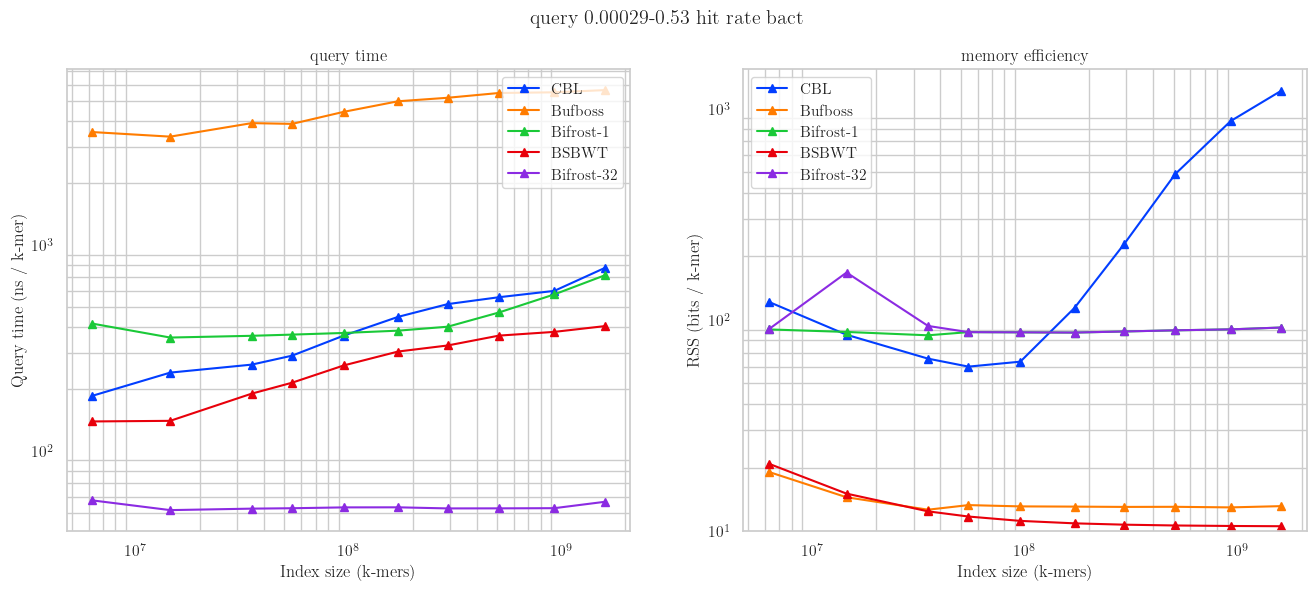

In [119]:
bact_res = read_res("../bbb_res/query_bact.txt")
h_r = [b / a for a, b in zip(bact_res["searched"], bact_res["found"])]
plot_time_and_space(bact_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact", "query_bact_mixed.pdf")

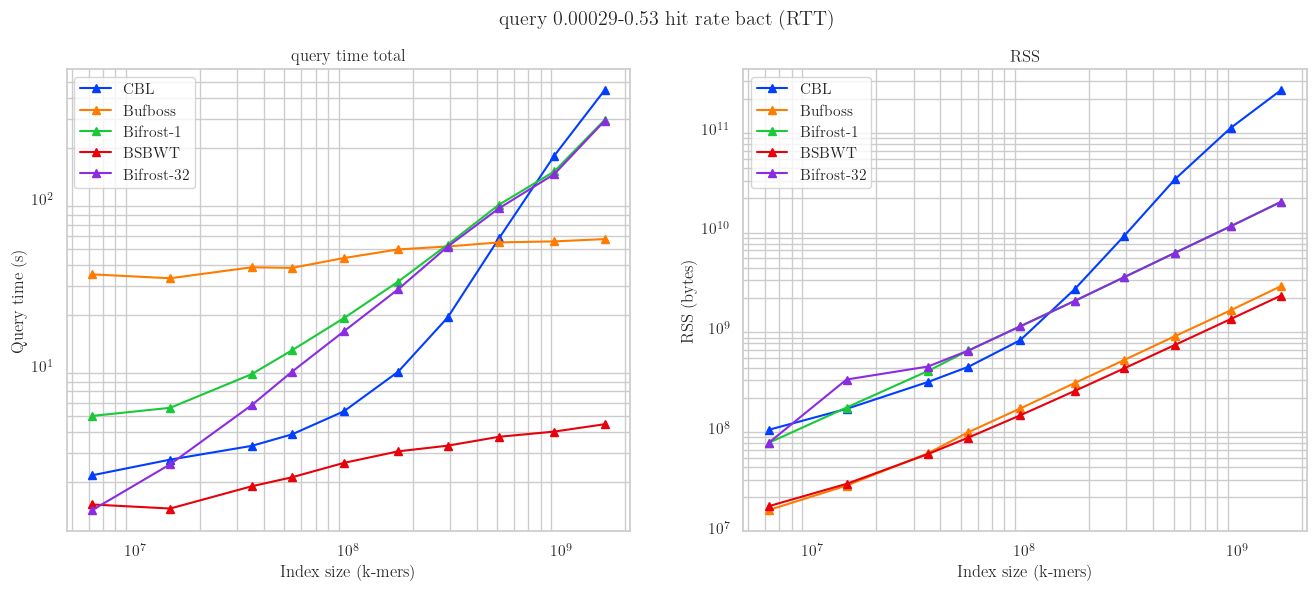

In [120]:
plot_total_time_and_space(bact_res, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact (RTT)", "query_bact_mixed_RTT.pdf")

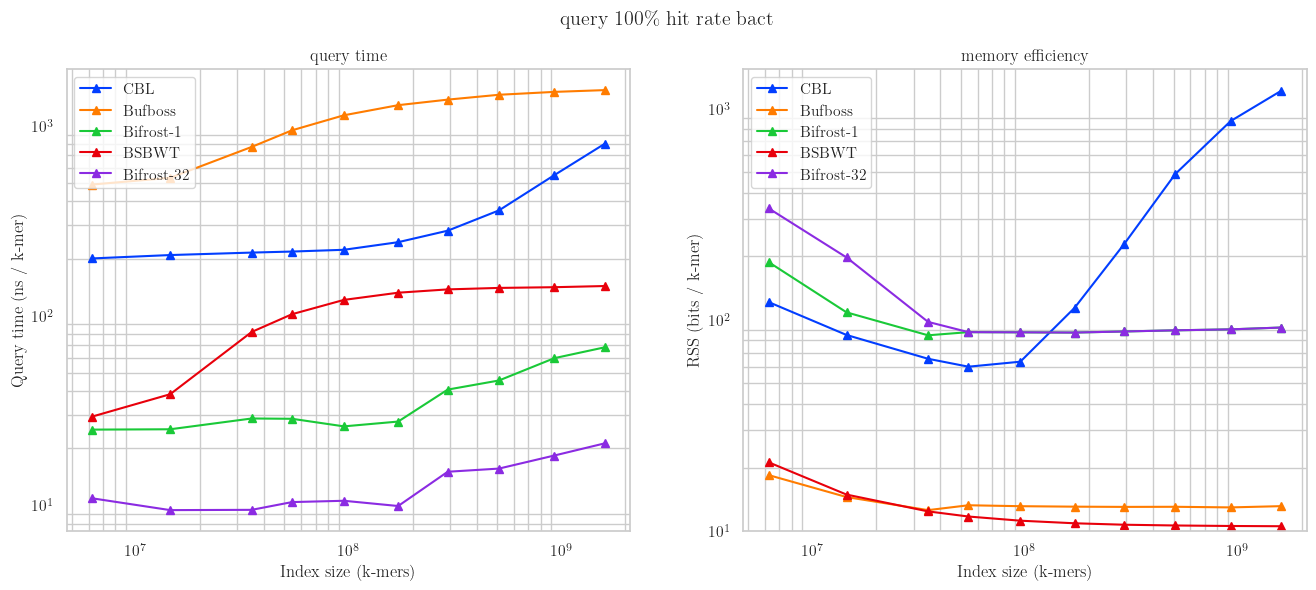

In [121]:
bact_res_pos = read_res("../bbb_res/query_bact_pos.txt")
h_r = [b / a for a, b in zip(bact_res_pos["searched"], bact_res_pos["found"])]
plot_time_and_space(bact_res_pos, "query 100\\% hit rate bact", "query_bact_pos.pdf")

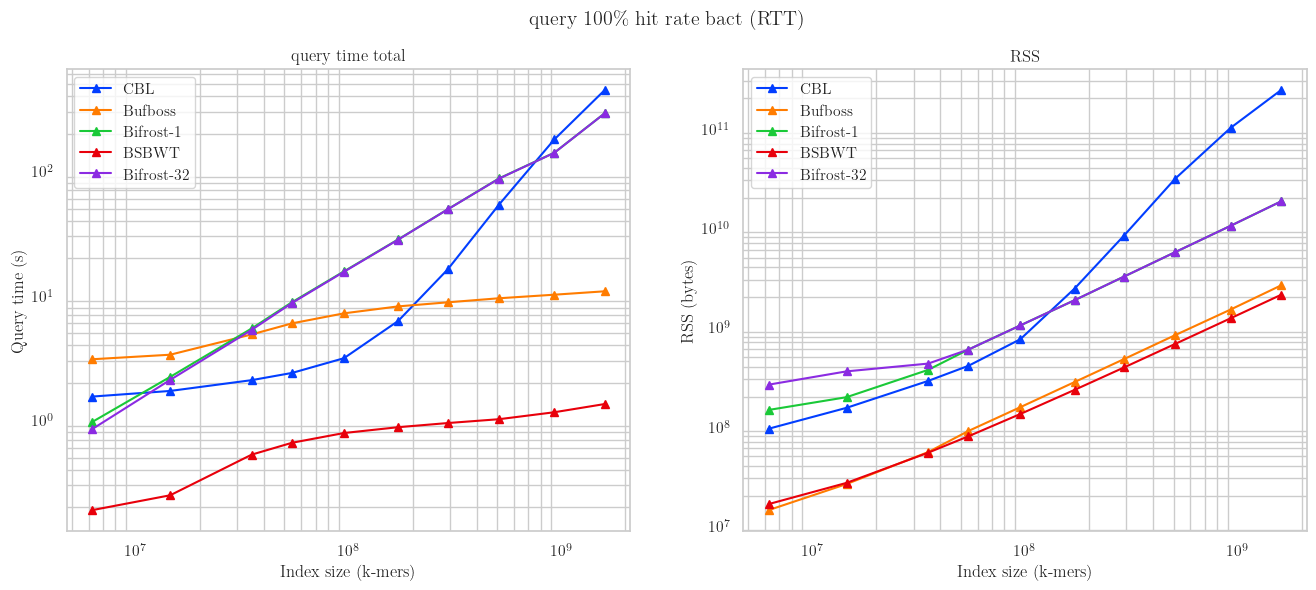

In [122]:
plot_total_time_and_space(bact_res_pos, f"query 100\\% hit rate bact (RTT)", "query_bact_pos_RTT.pdf")

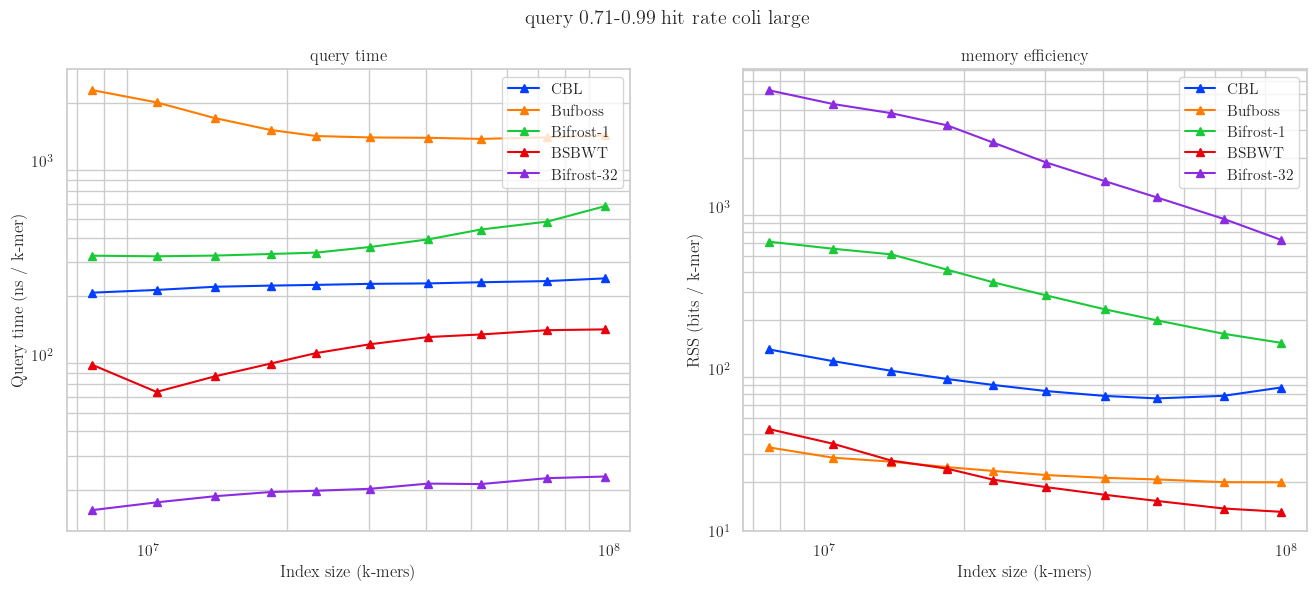

In [123]:
coli_res_large = read_res("../bbb_res/query_coli_big.txt")
h_r = [b / a for a, b in zip(coli_res_large["searched"], coli_res_large["found"])]
plot_time_and_space(coli_res_large, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate coli large", "query_coli_big.pdf")

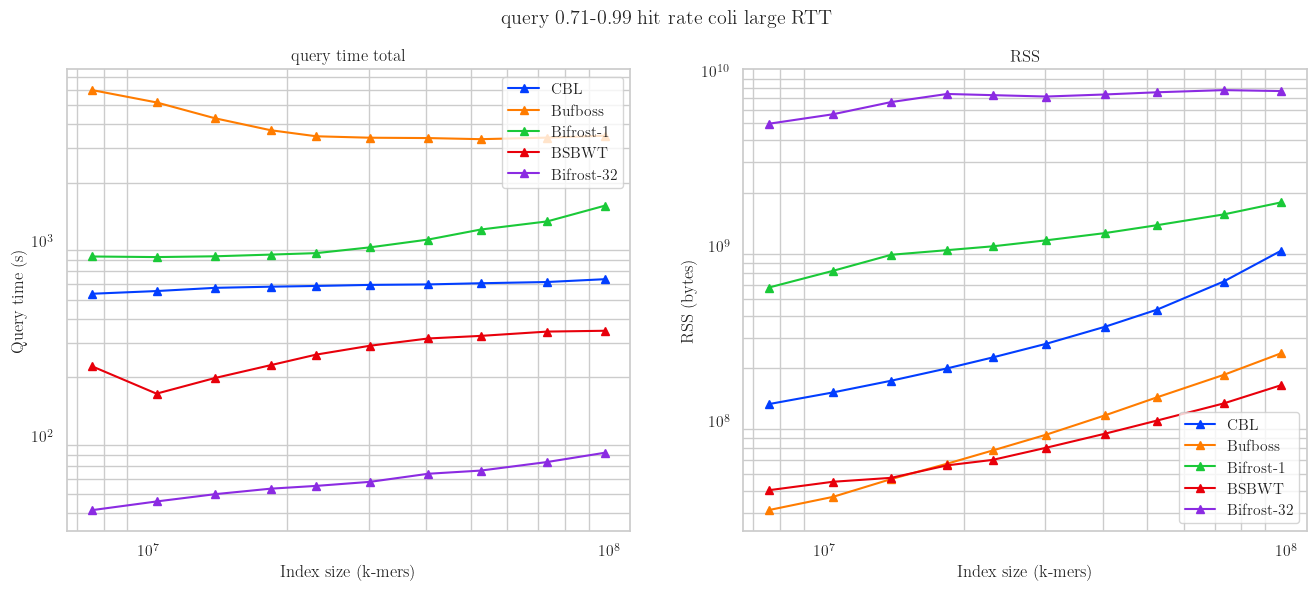

In [124]:
plot_total_time_and_space(coli_res_large, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate coli large RTT")

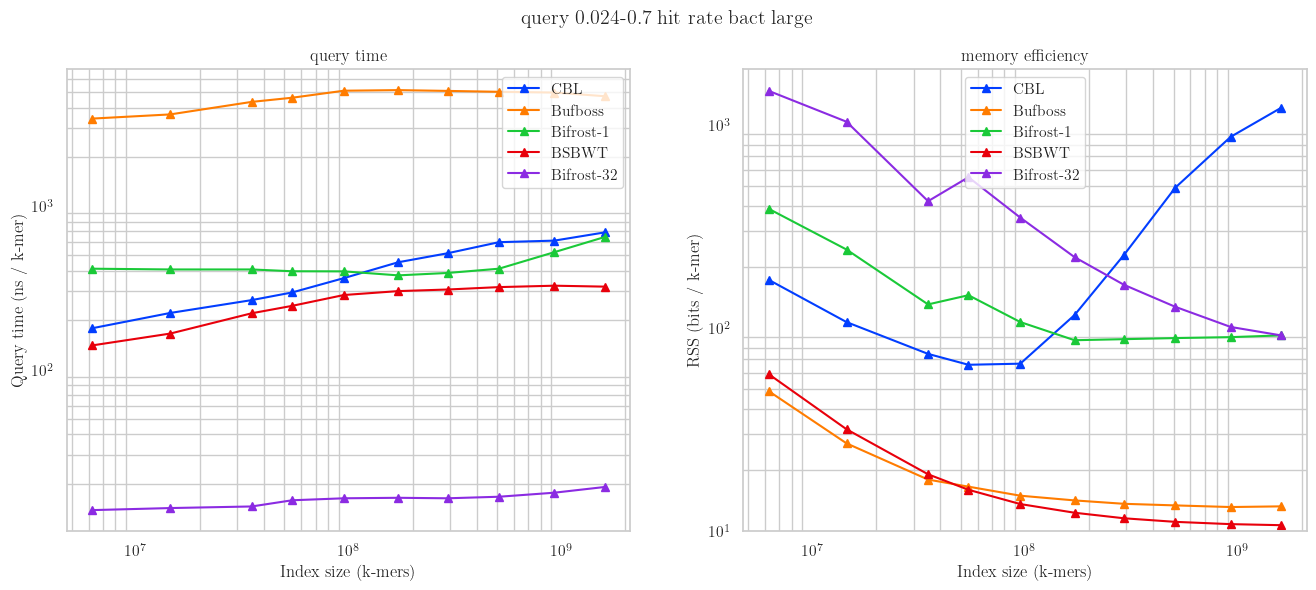

In [125]:
bact_res_large = read_res("../bbb_res/query_bact_big.txt")
h_r = [b / a for a, b in zip(bact_res_large["searched"], bact_res_large["found"])]
plot_time_and_space(bact_res_large, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact large")

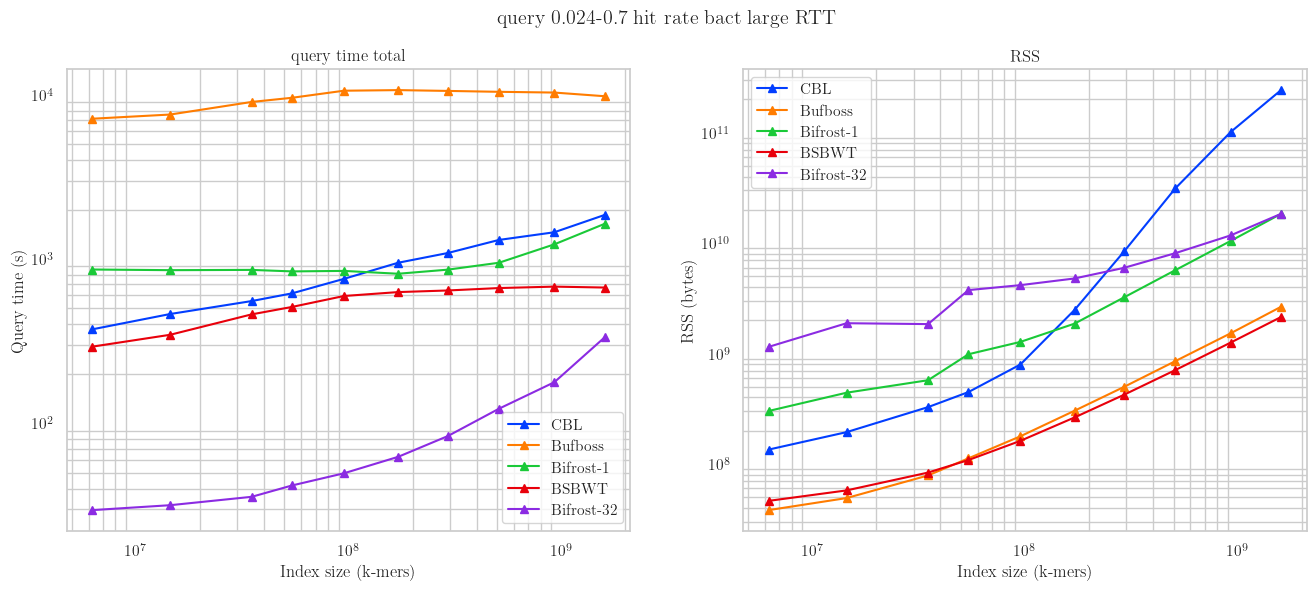

In [126]:
plot_total_time_and_space(bact_res_large, f"query {h_r[0]:.2}-{h_r[-1]:.2} hit rate bact large RTT")

In [127]:
dss = [coli_res, coli_res_pos, bact_res, bact_res_pos]
dsn = ["coli", "coli pos", "bact", "bact pos"]
keys = ['CBL', 'Bifrost-1', 'BSBWT', 'Bufboss']
for ds, n in zip(dss, dsn):
    print(n)
    for k in keys:
        it = [v[2] for v in ds["data"][k]]
        it = np.asarray(it)
        dt = [v[0] for v in ds["data"][k]]
        dt = np.asarray(dt)
        dt -= it
        dt /= ds["size"]
        it /= ds["searched"]
        print(k, np.mean(dt), np.mean(it))

coli
CBL 2.549551568854158e-08 2.341845040480169e-07
Bifrost-1 1.8886084491352578e-07 5.574156692830236e-07
BSBWT 4.2123909137712757e-10 1.0788162507188597e-07
Bufboss 1.2252958857812788e-09 1.544035054832035e-06
coli pos
CBL 2.2343215743560682e-08 2.2371144912380217e-07
Bifrost-1 1.8928129801138313e-07 3.310608253580568e-07
BSBWT 3.520922142142921e-10 8.800274324030994e-08
Bufboss 1.093107779996052e-09 9.470710593813452e-07
bact
CBL 7.813253971238804e-08 4.243402598123213e-07
Bifrost-1 1.5905363719178943e-07 4.4255179341472967e-07
BSBWT 1.7333630223263554e-09 2.7224452610443637e-07
Bufboss 2.271278449038427e-09 4.607190800374606e-06
bact pos
CBL 7.78698398113397e-08 3.302110064425143e-07
Bifrost-1 1.5828109773211577e-07 3.749791501705821e-08
BSBWT 4.101757796688986e-10 1.0664064254990887e-07
Bufboss 8.238393696799194e-10 1.1068003113717275e-06


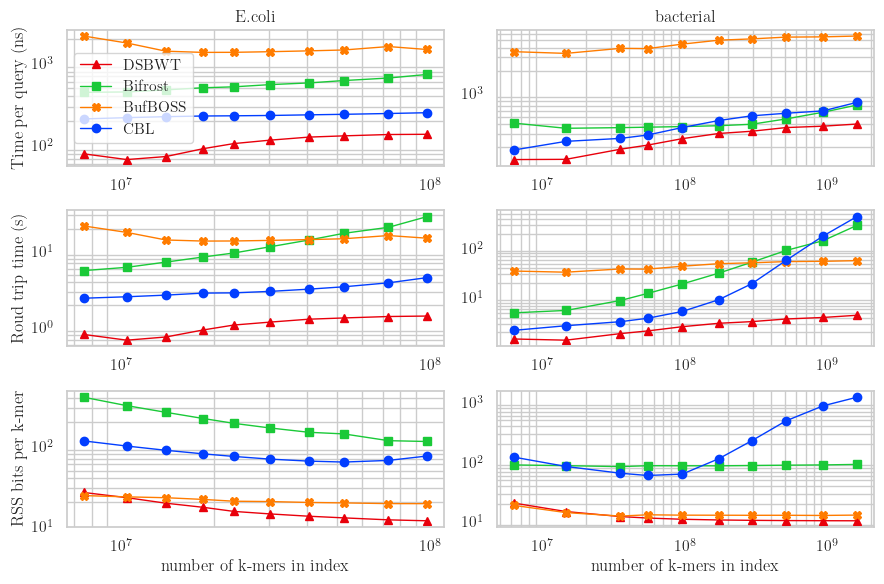

In [128]:
plt.figure(figsize=(9, 6))

for i, ((ds, dsp), name) in enumerate(zip(((coli_res, coli_res_pos), (bact_res, bact_res_pos)), ["E.coli", "bacterial"])):
    plt.subplot(3, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        handles += plt.plot(ds["size"], [vv[2] * 1000**3 / s for vv, s in zip(v, ds["searched"])], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time per query (ns)")
        plt.legend()
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(3, 2, i + 3)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        handles += plt.plot(ds["size"], [vv[0] for vv in v], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Roud trip time (s)")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(3, 2, i + 5)
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        plt.plot(ds["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, ds["size"])], linewidth=1,
             color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("RSS bits per k-mer")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("query_time_and_space.pdf", bbox_inches="tight")
#plt.show()

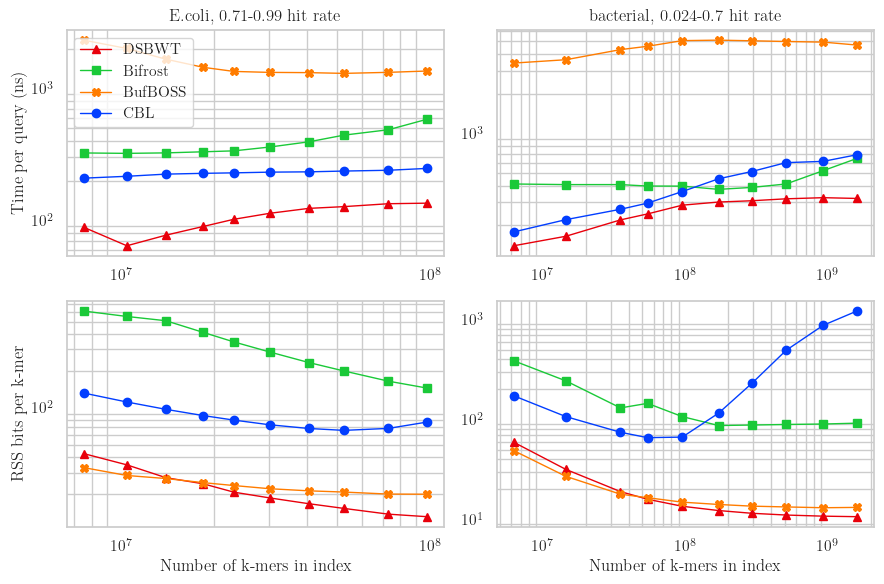

In [129]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip((coli_res_large, bact_res_large), ("E.coli", "bacterial"))):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        handles += plt.plot(ds["size"], [vv[2] * 1000**3 / s for vv, s in zip(v, ds["searched"])], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time per query (ns)")
        plt.legend()
    h_r = sorted([b / a for a, b in zip(ds["searched"], ds["found"])])
    plt.title(f"{name}, {h_r[0]:.2}-{h_r[-1]:.2} hit rate")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        plt.plot(ds["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, ds["size"])], linewidth=1,
             color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("RSS bits per k-mer")
    plt.xlabel("Number of k-mers in index")
    plt.grid(which='major')
    plt.grid(which='minor')
    #plt.legend()
plt.tight_layout()
plt.savefig("query_time_and_space.pdf", bbox_inches="tight")
#plt.show()

In [130]:
print(f"Coli: {coli_res_large["searched"][0]:.2E}\nbact: {bact_res_large["searched"][0]:.2E}")

Coli: 2.57E+09
bact: 2.09E+09


In [131]:
print(f"Coli: {coli_res_pos["searched"][0]:.2E}\nbact: {bact_res_pos["searched"][0]:.2E}")

Coli: 9.71E+06
bact: 6.28E+06


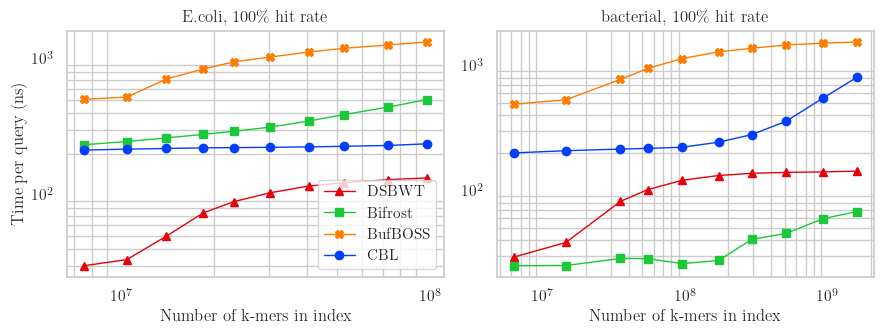

In [132]:
plt.figure(figsize=(9, 3.5))

for i, (ds, name) in enumerate(zip((coli_res_pos, bact_res_pos), ("E.coli", "bacterial"))):
    plt.subplot(1, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "32" in k:
            continue
        handles += plt.plot(ds["size"], [vv[2] * 1000**3 / s for vv, s in zip(v, ds["searched"])], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time per query (ns)")
        plt.legend()
    plt.title(f"{name}, 100\\% hit rate")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.xlabel("Number of k-mers in index")
    #plt.legend()
plt.tight_layout()
plt.savefig("query_pos_time_and_space.pdf", bbox_inches="tight")
#plt.show()

In [134]:
def f_num(val):
    if val < 10:
        return f"{val:.2f}"
    s_val = f"{val:.2E}".split("+")
    return s_val[0][:-1] + "e" + str(int(s_val[1]))

In [138]:
text = r"\begin{longtable}{ l | "
text += " | ".join("l" for _ in range(10))
text += "}\n\\hline\n"
text += "Index k-mers & "
text += " & ".join(f_num(v) for v in coli_res_large["size"])
text += "\\\\\n\\hline\n\\textbf{Mixed} \\\\\n\\hline\n"
text += "Query k-mers & "
text += " & ".join(f_num(v) for v in coli_res_large['searched'])
text += " \\\\\nfoud k-mers & "
text += " & ".join(f_num(v) for v in coli_res_large["found"])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "Query time (s)", "RSS (bytes)"], [0, 2, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in coli_res_large["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\textbf{Positive} \\\\\n\\hline\n"
text += "Query k-mers & "
text += " & ".join(f_num(v) for v in coli_res_large['searched'])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "Query time (s)", "RSS (bytes)"], [0, 2, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in coli_res_pos["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\end{longtable}\n"
print(text)

\begin{tabular}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Index k-mers & 7.55e6 & 1.04e7 & 1.39e7 & 1.84e7 & 2.31e7 & 3.02e7 & 4.04e7 & 5.25e7 & 7.32e7 & 9.75e7\\
\hline
\textbf{Mixed} \\
\hline
Query k-mers & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 & 2.57e9 \\
foud k-mers & 1.81e9 & 2.04e9 & 2.19e9 & 2.36e9 & 2.43e9 & 2.47e9 & 2.50e9 & 2.52e9 & 2.54e9 & 2.55e9 \\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 5.37e2 & 5.54e2 & 5.75e2 & 5.83e2 & 5.88e2 & 5.96e2 & 5.99e2 & 6.08e2 & 6.17e2 & 6.37e2 \\
BufBOSS & 5.97e3 & 5.16e3 & 4.28e3 & 3.72e3 & 3.46e3 & 3.40e3 & 3.39e3 & 3.34e3 & 3.40e3 & 3.48e3 \\
Bifrost & 8.34e2 & 8.28e2 & 8.36e2 & 8.53e2 & 8.68e2 & 9.29e2 & 1.02e3 & 1.15e3 & 1.26e3 & 1.52e3 \\
DSBWT & 2.27e2 & 1.65e2 & 1.98e2 & 2.31e2 & 2.61e2 & 2.90e2 & 3.16e2 & 3.26e2 & 3.43e2 & 3.46e2 \\
Bifrost 32t & 4.15e1 & 4.60e1 & 5.01e1 & 5.35e1 & 5.52e1 & 5.80e1 & 6.38e1 & 6.62e1 & 7.33e1 & 8.18e1 \\
\hline
Query time (s) & & & & & & & &

In [139]:
text = r"\begin{longtable}{ l | "
text += " | ".join("l" for _ in range(10))
text += "}\n\\hline\n"
text += "Index k-mers & "
text += " & ".join(f_num(v) for v in bact_res_large["size"])
text += "\\\\\n\\hline\n\\textbf{Mixed} \\\\\n\\hline\n"
text += "Query k-mers & "
text += " & ".join(f_num(v) for v in bact_res_large['searched'])
text += " \\\\\nfoud k-mers & "
text += " & ".join(f_num(v) for v in bact_res_large["found"])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "Query time (s)", "RSS (bytes)"], [0, 2, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in bact_res_large["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\textbf{Positive} \\\\\n\\hline\n"
text += "Query k-mers & "
text += " & ".join(f_num(v) for v in bact_res_large['searched'])
text += " \\\\\n"
for l, idx in zip(["Total time (s)", "Query time (s)", "RSS (bytes)"], [0, 2, 1]):
    text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
    for k, v in bact_res_pos["data"].items():
        text += f"{name_mapping[k]} & "
        text += " & ".join(f_num(vv[idx]) for vv in v)
        text += " \\\\\n"
text += "\\hline\n\\end{longtable}\n"
print(text)

\begin{tabular}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Index k-mers & 6.24e6 & 1.45e7 & 3.51e7 & 5.43e7 & 9.52e7 & 1.71e8 & 2.93e8 & 5.10e8 & 9.28e8 & 1.60e9\\
\hline
\textbf{Mixed} \\
\hline
Query k-mers & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 & 2.09e9 \\
foud k-mers & 4.92e7 & 2.35e8 & 2.80e8 & 5.20e8 & 5.91e8 & 9.09e8 & 1.11e9 & 1.24e9 & 1.35e9 & 1.46e9 \\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 3.73e2 & 4.62e2 & 5.54e2 & 6.17e2 & 7.56e2 & 9.48e2 & 1.09e3 & 1.31e3 & 1.45e3 & 1.85e3 \\
BufBOSS & 7.14e3 & 7.57e3 & 9.04e3 & 9.58e3 & 1.06e4 & 1.07e4 & 1.05e4 & 1.04e4 & 1.03e4 & 9.79e3 \\
Bifrost & 8.62e2 & 8.54e2 & 8.58e2 & 8.40e2 & 8.46e2 & 8.13e2 & 8.61e2 & 9.48e2 & 1.23e3 & 1.64e3 \\
DSBWT & 2.92e2 & 3.45e2 & 4.60e2 & 5.10e2 & 5.95e2 & 6.28e2 & 6.43e2 & 6.65e2 & 6.78e2 & 6.70e2 \\
Bifrost 32t & 2.96e1 & 3.17e1 & 3.56e1 & 4.18e1 & 4.95e1 & 6.24e1 & 8.34e1 & 1.22e2 & 1.78e2 & 3.33e2 \\
\hline
Query time (s) & & & & & & & &